In [1]:
import os
import cv2
from PIL import Image

# Pokemon image preprocessing

The image of Pokemons first need to be resize into a particular size

In [ ]:
# src = "/content/drive/Shareddrives/MachineLearning - 4 meme/Pokemon/images" #pokeRGB_black
# dst = "/content/drive/Shareddrives/MachineLearning - 4 meme/Pokemon/resized" # resized

# if os.path.isdir(dst) == False:
#   os.mkdir(dst)
#   for each in os.listdir(src):
#     img = cv2.imread(os.path.join(src, each))
#     img = cv2.resize(img, (64, 64))
#     cv2.imwrite(os.path.join(dst, each), img)

Convert the RGBA to RGB

In [ ]:
# src = "/content/drive/Shareddrives/MachineLearning - 4 meme/Pokemon/resized"
# dst = "/content/drive/Shareddrives/MachineLearning - 4 meme/Pokemon/resized_black"

# if os.path.isdir(dst) == False:
#   os.mkdir(dst)
#   for each in os.listdir(src):
#     png = Image.open(os.path.join(src,each))
#     # print each
#     if png.mode == 'RGBA':
#         png.load() # required for png.split()
#         background = Image.new("RGB", png.size, (0,0,0))
#         background.paste(png, mask=png.split()[3]) # 3 is the alpha channel
#         background.save(os.path.join(dst,each.split('.')[0] + '.jpg'), 'JPEG')
#     else:
#         png.convert('RGB')
#         png.save(os.path.join(dst,each.split('.')[0] + '.jpg'), 'JPEG')

# Pokedex analyzing

In [2]:
from torch.utils.data import DataLoader, ConcatDataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [3]:
IMAGE_SIZE = 64
BATCH_SIZE = 8
normalization_stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) # Convert channels from

## Image transformation

In [4]:
IMAGE_PATH = "/content/drive/Shareddrives/MachineLearning - 4 meme/Pokemon/Folder"

normal_dataset = ImageFolder(IMAGE_PATH, transform=T.Compose([
  T.Resize(IMAGE_SIZE),
  T.CenterCrop(IMAGE_SIZE),
  T.ToTensor(),
  T.Normalize(*normalization_stats)                                                        
]))

## Image augumented - flip

In [5]:
mirror_dataset = ImageFolder(IMAGE_PATH, transform=T.Compose([
  T.Resize(IMAGE_SIZE),
  T.CenterCrop(IMAGE_SIZE),
  T.RandomHorizontalFlip(p=1.0),
  T.ToTensor(),
  T.Normalize(*normalization_stats)                                                        
]))

## Image augumented - color change

In [6]:
color_dataset = ImageFolder(IMAGE_PATH, transform=T.Compose([
  T.Resize(IMAGE_SIZE),
  T.CenterCrop(IMAGE_SIZE),
  T.ColorJitter(0.5, 0.5, 0.5),
  T.ToTensor(),
  T.Normalize(*normalization_stats)                                                        
]))

In [7]:
# Combine into dataset
dataset_list = [normal_dataset, mirror_dataset, color_dataset]
dataset = ConcatDataset(dataset_list)

dataloader = DataLoader(dataset, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=False)

# Denormalize the image

In [8]:
def denorm(image):
  return image * normalization_stats[1][0] + normalization_stats[0][0]

# Visualize the Batch of images

In [9]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
def show_images(images, nmax=64):
  fig, ax = plt.subplots(figsize=(8, 8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dataloader, nmax=64):
  for images, _ in dataloader:
    show_images(images, nmax)
    break

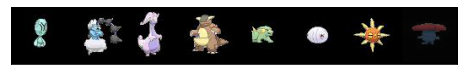

In [11]:
show_batch(dataloader)

# **Discriminator Models**

PyTorch neural network

In [12]:
import torch.nn as nn

Discriminator

In [13]:
disc = nn.Sequential(
    # Input is 3 x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 64 x 32 x 32
    
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 128 x 16 x 16
    
    nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 128 x 8 x 8
    
    nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 128 x 4 x 4
    
    # With a 4x4, we can condense the channels into a 1 x 1 x 1 to produce output
    nn.Conv2d(128, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)

# Generator Models

In [14]:
seed_size = 16

In [15]:
gen = nn.Sequential(
    # Input seed_size x 1 x 1
    nn.ConvTranspose2d(seed_size, 128, kernel_size=4, padding=0, stride=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Layer output: 256 x 4 x 4
    
    nn.ConvTranspose2d(128, 128, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Layer output: 128 x 8 x 8
    
    nn.ConvTranspose2d(128, 128, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Layer output: 64 x 16 x 16
    
    nn.ConvTranspose2d(128, 64, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # Layer output: 32 x 32 x 32
    
    nn.ConvTranspose2d(64, 3, kernel_size=4, padding=1, stride=2, bias=False),
    nn.Tanh()
    # Output: 3 x 64 x 64
)

# GPU Setup

In [16]:
def get_training_device():
    # Use the GPU if possible
    if torch.cuda.is_available():
        return torch.device('cuda')
    # Otherwise use the CPU :-(
    print('cpu')
    return torch.device('cpu')

def to_device(data, device):
    # This moves the tensors to the device (GPU, CPU)
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dataloader: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dataloader)

In [17]:
device = get_training_device()

In [18]:
dev_dataloader = DeviceDataLoader(dataloader, device)

# Training Functions

## Discriminator

In [19]:
def train_discriminator(real_pokemon, disc_optimizer):
  # Reset the gradient
  disc_optimizer.zero_grad()

  # Train on the real images
  real_predictions = discriminator(real_pokemon)
  # Add some noisy labels to make the discriminator think harder.
  real_targets = torch.rand(real_pokemon.size(0), 1, device=device) * (0.1 - 0) + 0
  # Can do binary loss function because it is a binary classifier
  real_loss = F.binary_cross_entropy(real_predictions, real_targets)
  # How well does the discriminator classify the real pokemon? (Higher score is better for the discriminator)
  real_score = torch.mean(real_predictions).item()

  # Make some latent tensors to seed the generator
  latent_batch = torch.randn(BATCH_SIZE, seed_size, 1, 1, device=device)

  # Get fake pokemons
  fake_pokemon = generator(latent_batch)

  # Train on the generator's current efforts to trick the discriminator
  gen_predictions = discriminator(fake_pokemon)
  # Add some noisy labels to make the discriminator think harder.
  gen_targets = torch.rand(fake_pokemon.size(0), 1, device=device) * (1 - 0.9) + 0.9
  gen_loss = F.binary_cross_entropy(gen_predictions, gen_targets)
  # How well did the discriminator classify the fake pokemon? (Lower score is better for the discriminator)
  gen_score = torch.mean(gen_predictions).item()

  # Update the discriminator weights
  total_loss = real_loss + gen_loss
  total_loss.backward()
  disc_optimizer.step()
  return total_loss.item(), real_score, gen_score

## Generator

In [20]:
def train_generator(gen_optimizer):
  # Reset the gradient
  gen_optimizer.zero_grad()

  # Generate fake pokemons
  latent_batch = torch.randn(BATCH_SIZE, seed_size, 1, 1, device=device)
  fake_pokemon = generator(latent_batch)

  # Test against the discriminator
  disc_predictions = discriminator(fake_pokemon)
  # We want the discriminator to think these images are real.
  targets = torch.zeros(fake_pokemon.size(0), 1, device=device)
  # How well did the generator do? (How much did the discriminator believe the generator?)
  loss = F.binary_cross_entropy(disc_predictions, targets)

  loss.backward()
  gen_optimizer.step()

# Get the result

In [21]:
import os
from torchvision.utils import save_image

RESULTS_DIR = 'results'
os.makedirs(RESULTS_DIR, exist_ok=True)

In [22]:
def save_results(index, latent_batch, show=True):
    # Generate fake pokemon
    fake_pokemon = generator(latent_batch)
    
    # Make the filename for the output
    fake_file = "result-image-{0:0=4d}.png".format(index)
    
    # Save the image
    save_image(denorm(fake_pokemon), os.path.join(RESULTS_DIR, fake_file), nrow=8)
    print("Result Saved!")
    
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_pokemon.cpu().detach(), nrow=8).permute(1, 2, 0))

# Full training process

In [23]:
model_DIR = 'models'
os.makedirs(model_DIR, exist_ok=True)

In [24]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

# Static generation seed batch
fixed_latent_batch = torch.randn(64, seed_size, 1, 1, device=device)

def train(epochs, learning_rate, start_idx=1):
  torch.cuda.empty_cache()

  # Track losses and scores
  disc_losses = []
  disc_scores = []
  gen_losses = []
  gen_scores = []

  # Create the optimizers
  disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.9))
  gen_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.9))

  # Run the loop
  for epoch in range(epochs):
    # Go through each image
    for real_image, _ in tqdm(dev_dataloader):
      # Train disciminator
      disc_loss, real_score, gen_score = train_discriminator(real_image, disc_optimizer)

      # Train generator
      gen_loss = train_generator(gen_optimizer)
    
    # Collect the results
    disc_losses.append(disc_loss)
    disc_scores.append(real_score)
    gen_losses.append(gen_loss)
    gen_scores.append(gen_score)

    print("Epoch: ", epoch + start_idx)
    print("Real score: ", real_score)
    print("Gen score: ", gen_score)

    # Save the images and show the progress
    save_results(epoch + start_idx, fixed_latent_batch, show=False)

  # Return stats
  return disc_losses, disc_scores, gen_losses, gen_scores

# Selecting Models

In [25]:
discriminator = disc

discriminator = to_device(discriminator, device)

generator = gen

generator = to_device(generator, device)

In [26]:
learning_rate = 0.00275
epochs = 50

In [27]:
history = train(epochs, learning_rate)

  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  1
Real score:  0.4014361798763275
Gen score:  0.2849388122558594
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  2
Real score:  0.2926637530326843
Gen score:  0.8473551273345947
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  3
Real score:  0.5146409869194031
Gen score:  0.6252980828285217
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  4
Real score:  0.43083059787750244
Gen score:  0.7751075029373169
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  5
Real score:  0.5277769565582275
Gen score:  0.4459388852119446
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  6
Real score:  0.07666286081075668
Gen score:  0.3676588535308838
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  7
Real score:  0.16002675890922546
Gen score:  0.6772763729095459
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  8
Real score:  0.24595849215984344
Gen score:  0.2982739210128784
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  9
Real score:  0.6484600305557251
Gen score:  0.8933764696121216
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  10
Real score:  0.6510529518127441
Gen score:  0.6035623550415039
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  11
Real score:  0.6219419836997986
Gen score:  0.9381061792373657
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  12
Real score:  0.6187728643417358
Gen score:  0.8776188492774963
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  13
Real score:  0.34398460388183594
Gen score:  0.7026714086532593
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  14
Real score:  0.36742493510246277
Gen score:  0.9446062445640564
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  15
Real score:  0.6687259674072266
Gen score:  0.852628767490387
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  16
Real score:  0.0615399107336998
Gen score:  0.5286697149276733
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  17
Real score:  0.06581439077854156
Gen score:  0.8236657381057739
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  18
Real score:  0.3657248616218567
Gen score:  0.5523043274879456
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  19
Real score:  0.3807690143585205
Gen score:  0.8418340682983398
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  20
Real score:  0.1695825755596161
Gen score:  0.8509871959686279
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  21
Real score:  0.17094646394252777
Gen score:  0.880332350730896
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  22
Real score:  0.11145113408565521
Gen score:  0.8483742475509644
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  23
Real score:  0.039289604872465134
Gen score:  0.7209670543670654
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  24
Real score:  0.12893393635749817
Gen score:  0.8758822679519653
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  25
Real score:  0.20359960198402405
Gen score:  0.9442369937896729
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  26
Real score:  0.43758293986320496
Gen score:  0.9769611954689026
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  27
Real score:  0.12765248119831085
Gen score:  0.8969495296478271
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  28
Real score:  0.2854105234146118
Gen score:  0.901134192943573
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  29
Real score:  0.006522191222757101
Gen score:  0.7376156449317932
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  30
Real score:  0.1931910216808319
Gen score:  0.9681861400604248
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  31
Real score:  0.028605571016669273
Gen score:  0.5359052419662476
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  32
Real score:  0.37052759528160095
Gen score:  0.9215661883354187
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  33
Real score:  0.11891969293355942
Gen score:  0.8599928021430969
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  34
Real score:  0.04696732014417648
Gen score:  0.7289994955062866
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  35
Real score:  0.02786046639084816
Gen score:  0.5281270742416382
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  36
Real score:  0.96885085105896
Gen score:  0.9532791376113892
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  37
Real score:  0.06977909058332443
Gen score:  0.9663644433021545
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  38
Real score:  0.04341548681259155
Gen score:  0.5715538263320923
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  39
Real score:  0.09007500112056732
Gen score:  0.9084120988845825
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  40
Real score:  0.29086554050445557
Gen score:  0.9045450687408447
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  41
Real score:  0.7505747079849243
Gen score:  0.9839471578598022
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  42
Real score:  0.02834770642220974
Gen score:  0.9678947329521179
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  43
Real score:  0.48191118240356445
Gen score:  0.9805488586425781
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  44
Real score:  0.11546121537685394
Gen score:  0.7650649547576904
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  45
Real score:  0.6674784421920776
Gen score:  0.8255785703659058
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  46
Real score:  0.06439460813999176
Gen score:  0.9243797063827515
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  47
Real score:  0.22988097369670868
Gen score:  0.9753144979476929
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  48
Real score:  0.4367479681968689
Gen score:  0.7483649253845215
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  49
Real score:  0.3748894929885864
Gen score:  0.9827711582183838
Result Saved!


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch:  50
Real score:  0.018891476094722748
Gen score:  0.9296711683273315
Result Saved!


In [28]:
!zip -r /content/poke.zip /content/results
from google.colab import files
files.download("/content/poke.zip")

  adding: content/results/ (stored 0%)
  adding: content/results/result-image-0026.png (deflated 0%)
  adding: content/results/result-image-0041.png (deflated 0%)
  adding: content/results/result-image-0039.png (deflated 0%)
  adding: content/results/result-image-0043.png (deflated 0%)
  adding: content/results/result-image-0036.png (deflated 0%)
  adding: content/results/result-image-0015.png (deflated 0%)
  adding: content/results/result-image-0010.png (deflated 0%)
  adding: content/results/result-image-0040.png (deflated 0%)
  adding: content/results/result-image-0011.png (deflated 0%)
  adding: content/results/result-image-0023.png (deflated 0%)
  adding: content/results/result-image-0050.png (deflated 0%)
  adding: content/results/result-image-0020.png (deflated 0%)
  adding: content/results/result-image-0002.png (deflated 0%)
  adding: content/results/result-image-0006.png (deflated 0%)
  adding: content/results/result-image-0048.png (deflated 0%)
  adding: content/results/resul

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Save model
    if epoch % 5 == 0:
      state = {
        'epoch': epoch,
        'disc_state_dict': discriminator.state_dict(),
        'gen_state_dict': generator.state_dict(),
        'disc_opt': disc_optimizer.state_dict(),
        'gen_opt': gen_optimizer.state_dict(),
        'disc_losses': disc_losses,
        'disc_scores': disc_scores,
        'gen_losses': gen_losses,
        'gen_scores': gen_scores
      }
      path = os.path.join(model_DIR, str(epoch) + '_' + 'model.pth')
      torch.save(state, filepath)

NameError: ignored